## 1. Time Series Classification Part 1: Feature Creation/Extraction

An interesting task in machine learning is the classification of time series. In this problem, we will classify the activities of humans based on time series obtained by a Wireless Sensor Network.


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFECV, RFE, SelectKBest, f_classif
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import GaussianNB, MultinomialNB


import warnings
warnings.filterwarnings('ignore')

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i.
Assume that you want to use the training set to classify bending from other activities, i.e., you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities.

In [2]:
def extract_features(data):
    features = {} 
    for column in data.columns[1:]:
        features[f'mean_{column}'] = data[column].mean()
        features[f'median_{column}'] = data[column].median()
        features[f'std_{column}'] = data[column].std()
    return pd.DataFrame(features, index=[0]) # return only one row for this instance

In [3]:
def load_data(foldername, num_tests):
    filepath = f'../data/AReM/{foldername}'
    column_name = ['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
    dataset_name = [file for file in os.listdir(filepath) if file.endswith('.csv')]
    training_data, testing_data = [], []
    for i, data in enumerate(dataset_name):
        df = pd.read_csv(f'{filepath}/{data}', skiprows=5, names=column_name, index_col=False)
        df = extract_features(df)
        if i < num_tests:
            testing_data.append(df)
        else:
            training_data.append(df)
    training_data = pd.concat(training_data, ignore_index=True)
    testing_data = pd.concat(testing_data, ignore_index=True)    
    return training_data, testing_data

In [4]:
folders = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
num_tests = [2, 2, 3, 3, 3, 3, 3]

training_data, testing_data = [], []
for folder, num_test in zip(folders, num_tests):
    training, testing = load_data(folder, num_test)
    # print(f"Folder: {folder}, Training: {training}, Testing: {testing}")
    training_data.append(training)
    testing_data.append(testing) 

training_data = pd.concat(training_data, ignore_index=True)
testing_data = pd.concat(testing_data, ignore_index=True)   

print("Training Data: \n", training_data)
print("Testing Data: \n", testing_data)

Training Data: 
     mean_avg_rss12  median_avg_rss12  std_avg_rss12  mean_var_rss12  \
0        42.179812            43.500       3.670666        0.696042   
1        41.678063            41.750       2.243490        0.535979   
2        40.624792            40.500       1.476967        0.358604   
3        42.812812            42.500       1.435550        0.372437   
4        43.954500            44.330       1.558835        0.426250   
..             ...               ...            ...             ...   
64       34.322750            35.250       4.752477        4.456333   
65       34.473188            35.000       4.796705        4.359312   
66       34.873229            35.250       4.531720        4.380583   
67       34.599875            35.125       4.731790        4.398833   
68       34.225875            34.750       4.441798        4.354500   

    median_var_rss12  std_var_rss12  mean_avg_rss13  median_avg_rss13  \
0              0.500       0.630860       22.183625      

In [5]:
time_series = ['avg_rss12', 'var_rss12', 'var_rss23']

filtered_training = pd.DataFrame()
for ts in time_series:
    filtered_data = training_data.filter(regex=f'{ts}$')
    filtered_training = pd.concat([filtered_training, filtered_data], axis=1)

filtered_training


mean_avg_rss12  median_avg_rss12  std_avg_rss12  mean_var_rss12  \
0        42.179812            43.500       3.670666        0.696042   
1        41.678063            41.750       2.243490        0.535979   
2        40.624792            40.500       1.476967        0.358604   
3        42.812812            42.500       1.435550        0.372437   
4        43.954500            44.330       1.558835        0.426250   
..             ...               ...            ...             ...   
64       34.322750            35.250       4.752477        4.456333   
65       34.473188            35.000       4.796705        4.359312   
66       34.873229            35.250       4.531720        4.380583   
67       34.599875            35.125       4.731790        4.398833   
68       34.225875            34.750       4.441798        4.354500   

    median_var_rss12  std_var_rss12  mean_var_rss23  median_var_rss23  \
0              0.500       0.630860        0.613521             0.500   
1              0.500       0.405469        0.383292             0.430   
2              0.430       0.322605        0.570583             0.430   
3              0.470       0.289158        0.571083             0.430   
4              0.470       0.338690        0.493292             0.430   
..               ...            ...             ...               ...   
64             3.900       2.599284        3.432563             3.200   
65             3.960       2.388746        3.340458             3.090   
66             3.925       2.435437        3.424646             3.270   
67             4.025       2.538521        3.289542             3.015   
68             3.900       2.518991        3.479542             3.270   

    std_var_rss23  
0        0.524317  
1        0.389164  
2        0.582915  
3        0.601010  
4        0.513506  
..            ...  
64       1.732727  
65       1.699114  
66       1.690960  
67       1.680170  
68       1.761146  

[69 rows x 9 columns]

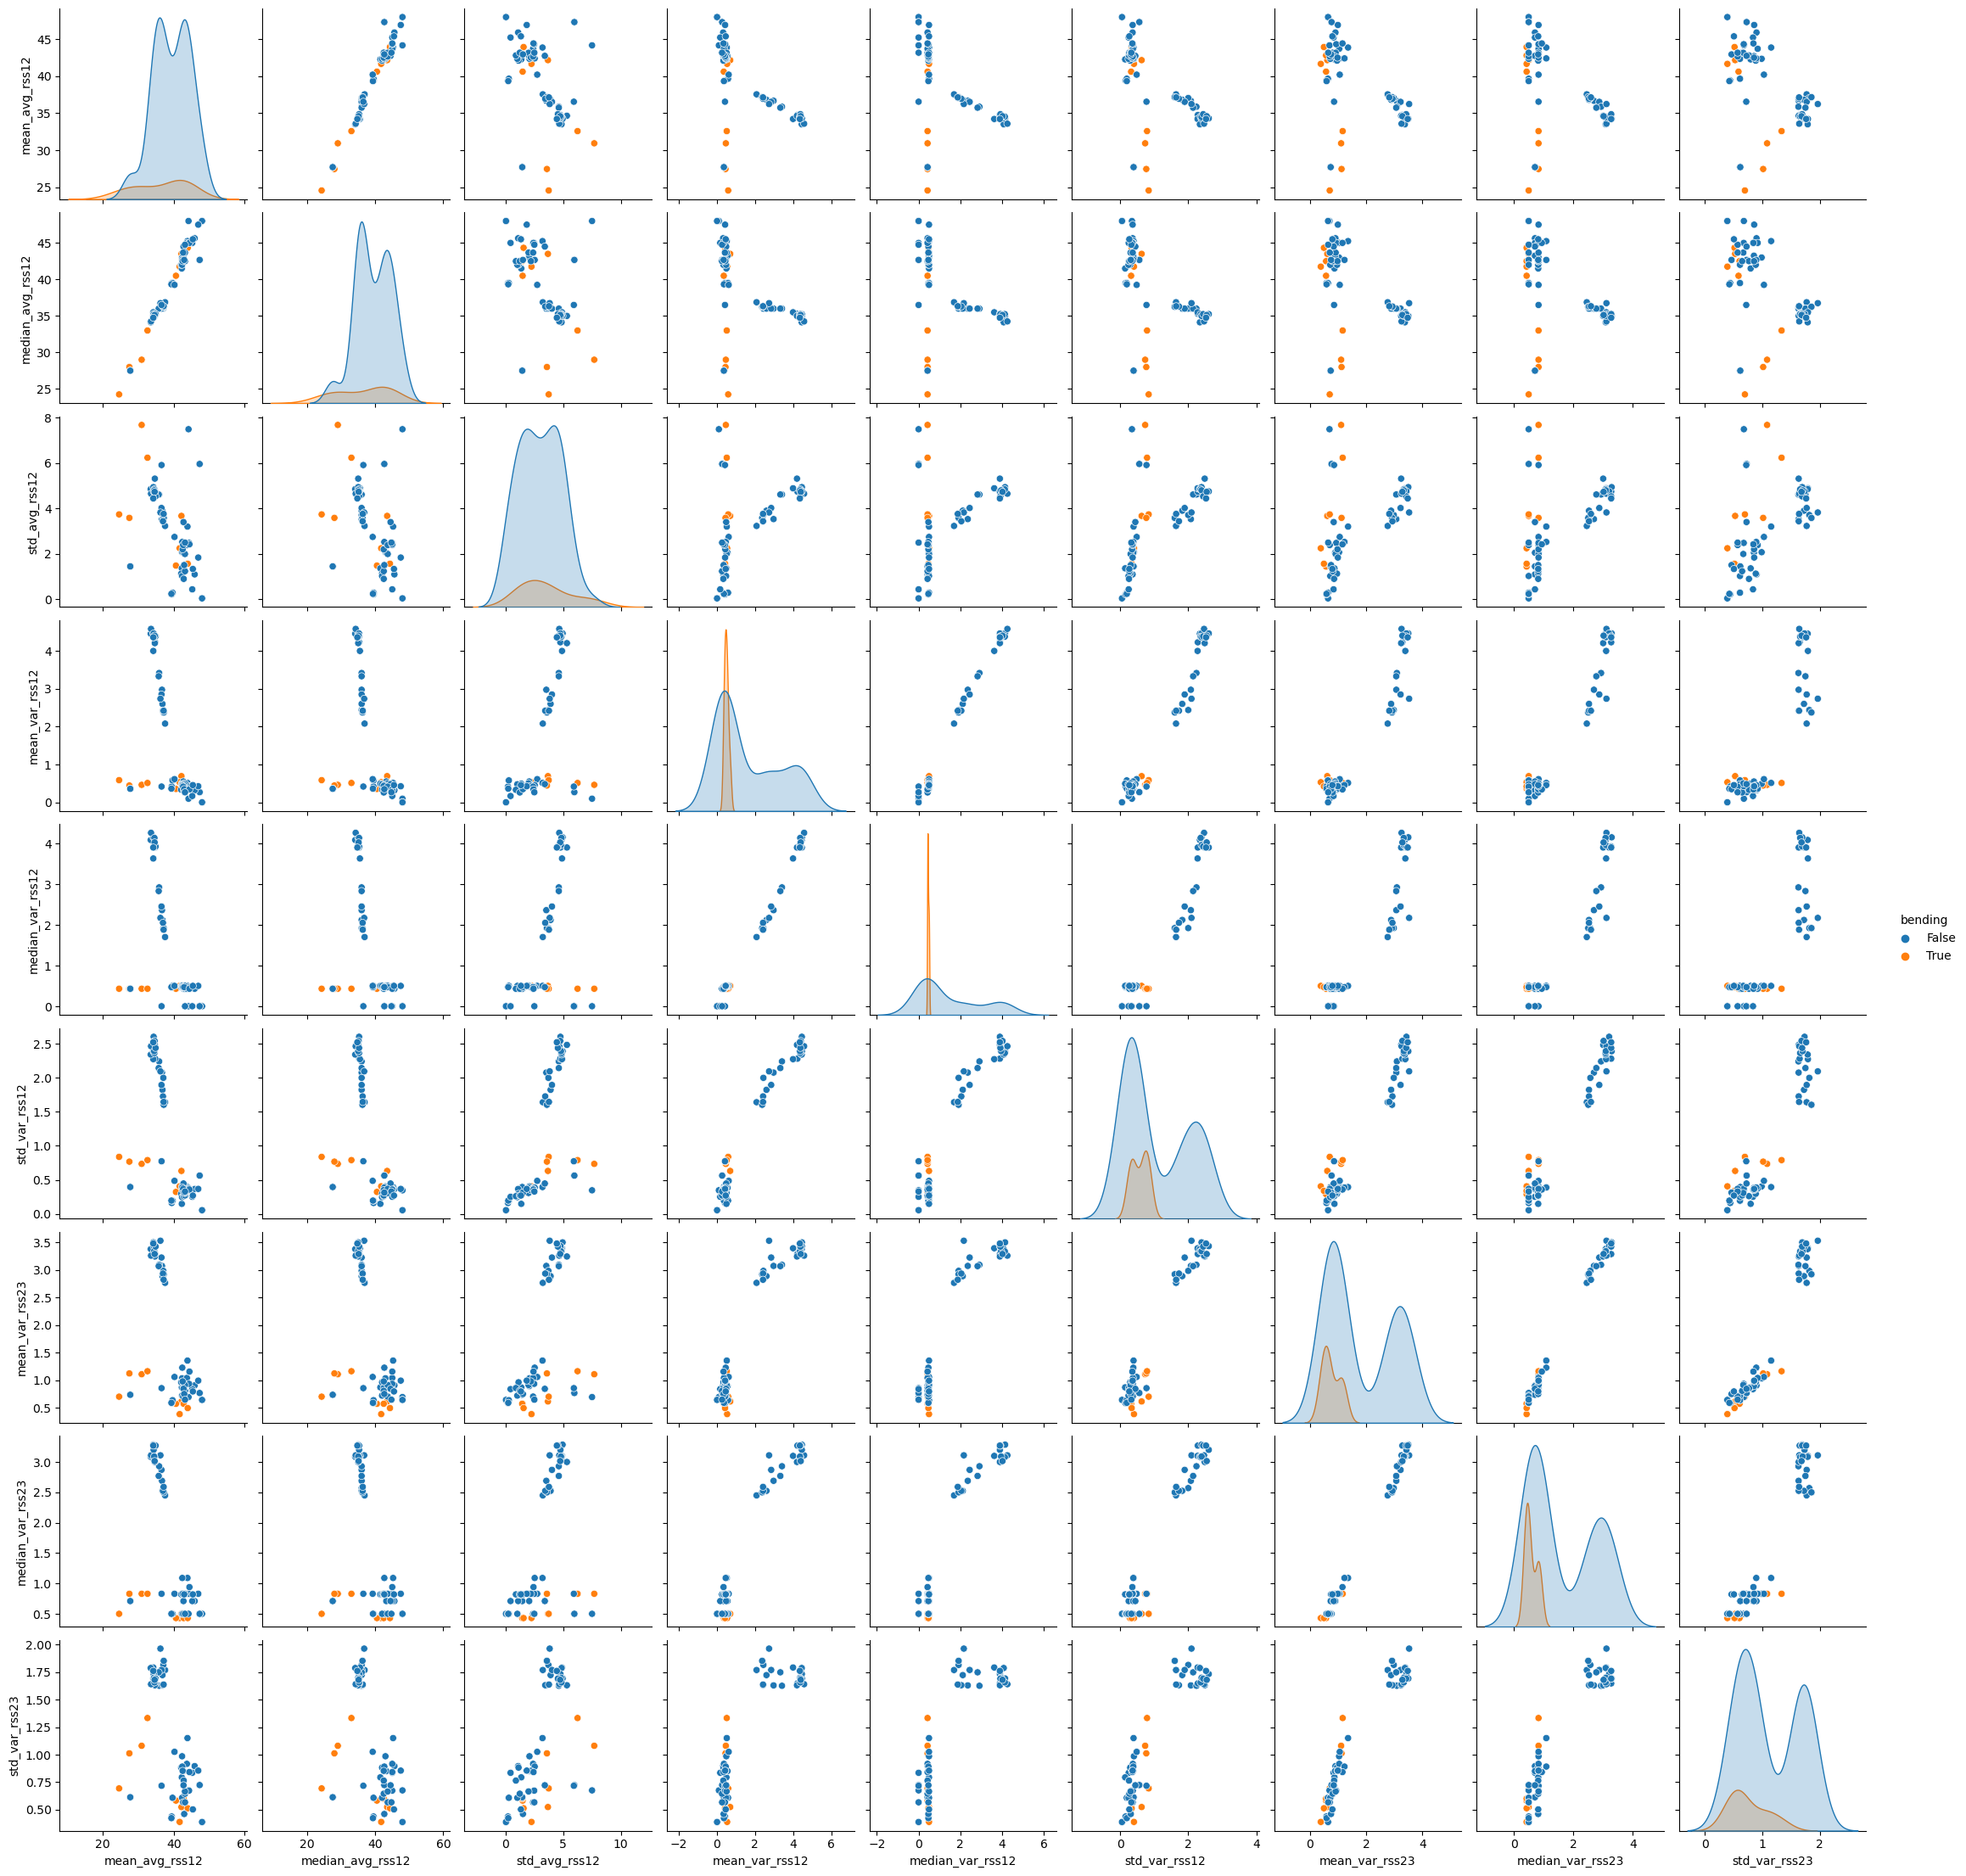

In [6]:
filtered_training['bending'] = [True if i < 9 else False for i in filtered_training.index] # first 9 rows are bending in training data

sns.pairplot(filtered_training, hue='bending')


#### ii.
Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 2(a)i, i.e., depict scatter plots of the features extracted from both parts of the time series 1, 2, and 6. Do you see any considerable difference in the results with those of 2(a)i?


In [7]:
def extract_features(data, num):
    features = {} 
    for column in data.columns[1:]:
        features[f'mean_{column}_{num}'] = data[column].mean()
        features[f'median_{column}_{num}'] = data[column].median()
        features[f'std_{column}_{num}'] = data[column].std()
    return pd.DataFrame(features, index=[0]) # return only one row for this instance

In [8]:
def load_data_for_train_split(foldername, num_tests):
    filepath = f'../data/AReM/{foldername}'
    column_name = ['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
    dataset_name = [file for file in os.listdir(filepath) if file.endswith('.csv')]
    training_data = []
    for i, data in enumerate(dataset_name):
        if i < num_tests:
            continue
        df = pd.read_csv(f'{filepath}/{data}', skiprows=5, names=column_name, index_col=False)
        midpoint = len(df) // 2
        first_half = df.iloc[:midpoint]
        second_half = df.iloc[midpoint:]
        first_half = extract_features(first_half, 1)
        second_half = extract_features(second_half, 2)
        full_data = pd.concat([first_half, second_half], axis=1)
        training_data.append(full_data)
    training_data = pd.concat(training_data, ignore_index=True)    
    return training_data

In [9]:
folders = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
num_tests = [2, 2, 3, 3, 3, 3, 3]

training_data = []
for folder, num_test in zip(folders, num_tests):
    training = load_data_for_train_split(folder, num_test)
    training_data.append(training)
training_data = pd.concat(training_data, ignore_index=True) 

print("Training Data: \n", training_data)

Training Data: 
     mean_avg_rss12_1  median_avg_rss12_1  std_avg_rss12_1  mean_var_rss12_1  \
0          43.278875              45.000         3.473355          0.673292   
1          41.621208              42.330         3.118644          0.623083   
2          40.946958              41.250         1.102963          0.375667   
3          42.643292              42.500         0.641849          0.355000   
4          44.057167              44.500         1.556971          0.381042   
..               ...                 ...              ...               ...   
64         34.036750              34.415         4.872880          4.778292   
65         34.916792              35.375         4.634209          4.262333   
66         34.920792              35.330         4.272282          4.177958   
67         34.836458              35.750         4.869092          4.257750   
68         34.329333              34.710         4.549837          4.315917   

    median_var_rss12_1  std_var_rs

In [10]:
time_series = ['avg_rss12', 'var_rss12', 'var_rss23']

filtered_training = pd.DataFrame()
for ts in time_series:
    regax = f'{ts}_[1|2]$'
    filtered_data = training_data.filter(regex=regax)
    filtered_training = pd.concat([filtered_training, filtered_data], axis=1)

filtered_training

mean_avg_rss12_1  median_avg_rss12_1  std_avg_rss12_1  mean_avg_rss12_2  \
0          43.278875              45.000         3.473355         41.080750   
1          41.621208              42.330         3.118644         41.734917   
2          40.946958              41.250         1.102963         40.302625   
3          42.643292              42.500         0.641849         42.982333   
4          44.057167              44.500         1.556971         43.851833   
..               ...                 ...              ...               ...   
64         34.036750              34.415         4.872880         34.608750   
65         34.916792              35.375         4.634209         34.029583   
66         34.920792              35.330         4.272282         34.825667   
67         34.836458              35.750         4.869092         34.363292   
68         34.329333              34.710         4.549837         34.122417   

    median_avg_rss12_2  std_avg_rss12_2  mean_var_rss12_1  median_var_rss12_1  \
0               42.000         3.537481          0.673292               0.485   
1               41.500         0.595920          0.623083               0.500   
2               39.415         1.716686          0.375667               0.470   
3               43.375         1.913255          0.355000               0.470   
4               43.500         1.557168          0.381042               0.470   
..                 ...              ...               ...                 ...   
64              35.500         4.621400          4.778292               4.030   
65              34.500         4.923609          4.262333               3.850   
66              35.250         4.785599          4.177958               3.865   
67              35.000         4.588342          4.257750               3.770   
68              34.750         4.338107          4.315917               3.880   

    std_var_rss12_1  mean_var_rss12_2  median_var_rss12_2  std_var_rss12_2  \
0          0.634285          0.718792               0.500         0.627915   
1          0.489595          0.448875               0.500         0.273050   
2          0.328089          0.341542               0.430         0.316790   
3          0.258298          0.389875               0.470         0.316617   
4          0.329540          0.471458               0.500         0.342346   
..              ...               ...                 ...              ...   
64         2.762730          4.134375               3.740         2.387460   
65         2.396878          4.456292               4.195         2.381634   
66         2.341763          4.583208               4.070         2.514203   
67         2.512633          4.539917               4.075         2.561608   
68         2.470266          4.393083               4.025         2.571376   

    mean_var_rss23_1  median_var_rss23_1  std_var_rss23_1  mean_var_rss23_2  \
0           0.640958               0.765         0.554542          0.586083   
1           0.419083               0.430         0.411200          0.347500   
2           0.589000               0.000         0.647856          0.552167   
3           0.608583               0.430         0.624834          0.533583   
4           0.598250               0.500         0.526656          0.388333   
..               ...                 ...              ...               ...   
64          3.543708               3.255         1.703098          3.321417   
65          3.439917               3.200         1.737420          3.241000   
66          3.430625               3.270         1.781928          3.418667   
67          3.169625               2.870         1.647640          3.409458   
68          3.381250               3.180         1.725690          3.577833   

    median_var_rss23_2  std_var_rss23_2  
0                0.470         0.491873  
1                0.430         0.363144  
2                0.430         0.510494  
3                0.430      

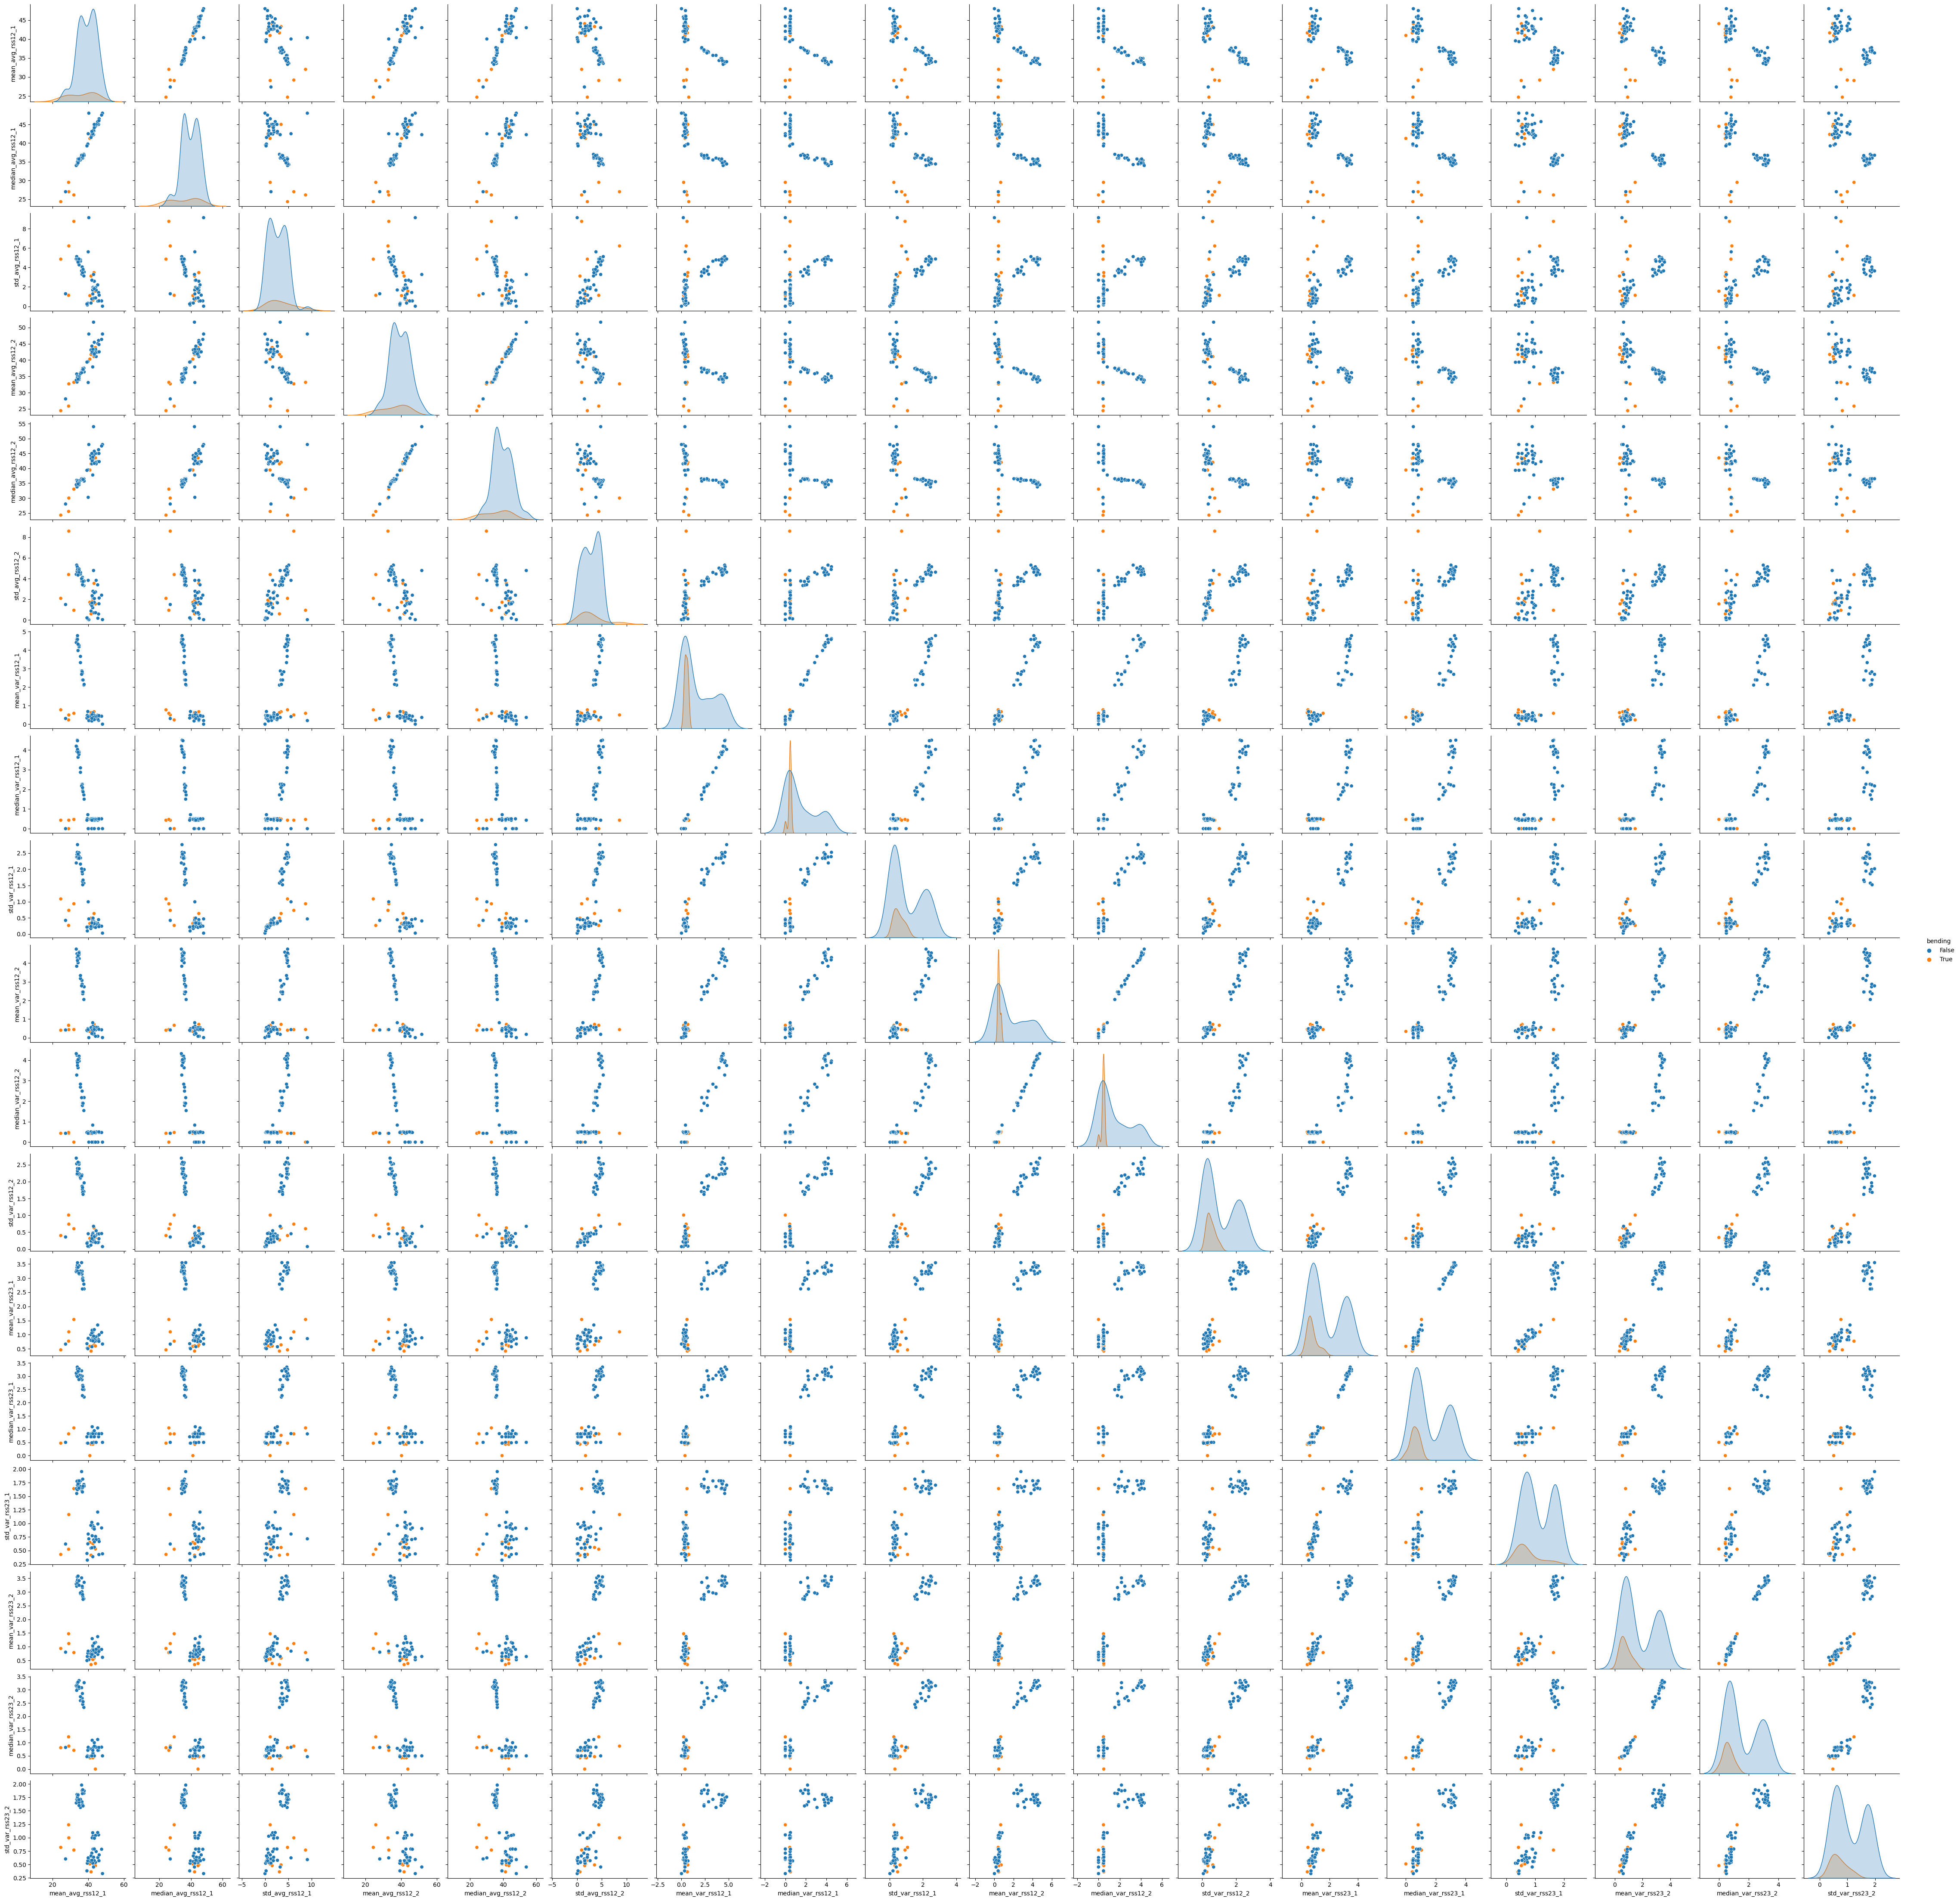

In [11]:
filtered_training['bending'] = [True if i < 9 else False for i in filtered_training.index] # first 9 rows are bending in training data

sns.pairplot(filtered_training, hue='bending')

There are clearer boundry between bending and other activities in this plot.


#### iii.
Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance. Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and refit a logistic regression model using your pruned set of features.Alternatively, you can use backward selection using sklearn.feature_selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair (l, p), where p is the number of features used in recursive feature elimination. Explain what the right way and the wrong way are to perform cross-validation in this problem. Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross-validation. Research what it means and use it if needed.


In [12]:
def split_into_n(foldername, num_tests, n):
    filepath = f'../data/AReM/{foldername}'
    column_name = ['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
    dataset_name = [file for file in os.listdir(filepath) if file.endswith('.csv')]
    training_data, testing_data = [], []
    for i, data in enumerate(dataset_name):
        df = pd.read_csv(f'{filepath}/{data}', skiprows=5, names=column_name, index_col=False)
        df.drop(['time'], axis=1, inplace=True)
        sets = np.array_split(df, n)
        full_data= pd.DataFrame()
        for j, subset in enumerate(sets):
            subset = extract_features(subset, j)
            full_data = pd.concat([full_data, subset], axis=1)
        if i < num_tests:
            testing_data.append(full_data)
        else:
            training_data.append(full_data)
    training_data = pd.concat(training_data, ignore_index=True)    
    testing_data = pd.concat(testing_data, ignore_index=True)
    return training_data, testing_data

In [13]:
folders = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
num_tests = [2, 2, 3, 3, 3, 3, 3]
split_n = [i for i in range(1, 21)]
results = {}
model = LogisticRegression()
for n in split_n:
    training_data = []
    for folder, num_test in zip(folders, num_tests):
        training, _ = split_into_n(folder, num_test, n)
        training_data.append(training)
    training_data = pd.concat(training_data, ignore_index=True)
    training_data['bending'] = [1 if i < 9 else 0 for i in training_data.index] 

    X_train = training_data.drop('bending', axis=1)
    y_train = training_data['bending']

    kf = StratifiedKFold(n_splits=5)
    rfecv = RFECV(estimator=model, cv=kf, scoring='accuracy')
    rfecv = rfecv.fit(X_train, y_train)

    results[f'Split {n}'] = {
        'Optimal num of features': rfecv.n_features_,
        'Error': rfecv.cv_results_['mean_test_score'].max()
    }

In [14]:
for key, value in sorted(results.items(), key=lambda x: x[1]['Error']):
    print(f"{key}: {value}")

Split 4: {'Optimal num of features': 3, 'Error': 0.9417582417582417}
Split 2: {'Optimal num of features': 2, 'Error': 0.9560439560439562}
Split 3: {'Optimal num of features': 39, 'Error': 0.9560439560439562}
Split 5: {'Optimal num of features': 7, 'Error': 0.9560439560439562}
Split 11: {'Optimal num of features': 7, 'Error': 0.9560439560439562}
Split 13: {'Optimal num of features': 4, 'Error': 0.9560439560439562}
Split 14: {'Optimal num of features': 1, 'Error': 0.9560439560439562}
Split 16: {'Optimal num of features': 10, 'Error': 0.9560439560439562}
Split 17: {'Optimal num of features': 8, 'Error': 0.9560439560439562}
Split 15: {'Optimal num of features': 6, 'Error': 0.9571428571428571}
Split 6: {'Optimal num of features': 39, 'Error': 0.9571428571428573}
Split 8: {'Optimal num of features': 33, 'Error': 0.9571428571428573}
Split 9: {'Optimal num of features': 60, 'Error': 0.9571428571428573}
Split 12: {'Optimal num of features': 110, 'Error': 0.9571428571428573}
Split 1: {'Optimal n

- The wrong way: Doing cross validation in different set of validation data.
- The right way: Doing cross validation in same set of validation data to see how parameters perform.



#### iv.
Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.


In [15]:
best_split, best_l = 10, 7 # (20, 36) is the best split but there are too many features (insufficient data) and it will cause error in the stats model

folders = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
num_tests = [2, 2, 3, 3, 3, 3, 3]
split_n = [i for i in range(1, 21)]
results = {}
model = LogisticRegression()

training_data = []
for folder, num_test in zip(folders, num_tests):
    training, _ = split_into_n(folder, num_test, n)
    training_data.append(training)
training_data = pd.concat(training_data, ignore_index=True)
training_data['bending'] = [1 if i < 9 else 0 for i in training_data.index] 

X_train = training_data.drop('bending', axis=1)
y_train = training_data['bending']

rfe = RFE(estimator=model, n_features_to_select=best_l)
rfe = rfe.fit(X_train, y_train)

y_pred = rfe.predict(X_train)

conf_matrix = confusion_matrix(y_train, y_pred)
print("Confusion Matrix: \n", conf_matrix)

Confusion Matrix: 
 [[60  0]
 [ 0  9]]


In [16]:
y_pred_prob = rfe.predict_proba(X_train)[:, 1] # (n_samples, n_classes), we want the probability of the positive class
# print(rfe.predict_proba(X_train))
# print("Predicted Probabilities: \n", y_pred_prob)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_train, y_pred_prob)
# print("False Positive Rate: ", fpr)
# print("True Positive Rate: ", tpr)

# Calculate AUC
roc_auc = roc_auc_score(y_train, y_pred_prob)
print("ROC AUC: ", roc_auc)

ROC AUC:  1.0


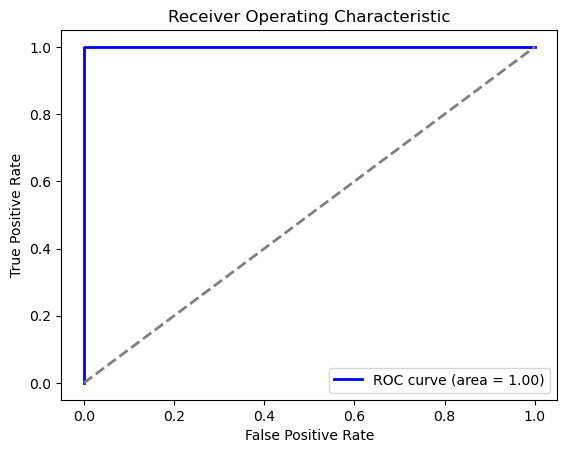

In [17]:
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [18]:
X_train_selected = X_train.loc[:, rfe.support_]
# print(X_train_selected)

X_train_selected = sm.add_constant(X_train_selected)
logit_model = sm.Logit(y_train, X_train_selected)
result = logit_model.fit(method='bfgs')

print(result.summary())

         Current function value: 0.000004
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
                           Logit Regression Results                           
Dep. Variable:                bending   No. Observations:                   69
Model:                          Logit   Df Residuals:                       61
Method:                           MLE   Df Model:                            7
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                   1.000
Time:                        23:34:45   Log-Likelihood:            -0.00024659
converged:                      False   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 3.042e-09
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -139.8904   8.09e+06  -1.73e-05      1.000 


#### v. 
Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.


In [19]:
best_split, best_l = 10, 7

folders = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
num_tests = [2, 2, 3, 3, 3, 3, 3]
split_n = [i for i in range(1, 21)]
results = {}
model = LogisticRegression()

training_data, testing_data  = [], []
for folder, num_test in zip(folders, num_tests):
    training, testing = split_into_n(folder, num_test, n)
    training_data.append(training)
    testing_data.append(testing)
training_data = pd.concat(training_data, ignore_index=True)
testing_data = pd.concat(testing_data, ignore_index=True)
training_data['bending'] = [1 if i < 9 else 0 for i in training_data.index] 
testing_data['bending'] = [1 if i < 9 else 0 for i in testing_data.index]

X_train = training_data.drop('bending', axis=1)
y_train = training_data['bending']
X_test = testing_data.drop('bending', axis=1)
y_test = testing_data['bending']

rfe = RFE(estimator=model, n_features_to_select=best_l)
rfe = rfe.fit(X_train, y_train)

y_pred = rfe.predict(X_test)
score = rfe.score(X_test, y_test)

conf_matrix = confusion_matrix(y_test, y_pred)

print("Test Error: ", 1 - score)
print("Confusion Matrix: \n", conf_matrix)

Test Error:  0.4736842105263158
Confusion Matrix: 
 [[10  0]
 [ 9  0]]



#### vi. 
Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?


Yes, the classes are well-seperated because the p values are 1, which means we have no evidence to reject null hypothesis. As a result, the features does not provide useful information for predicting 'bending'. It may cause instability in calculating logistic regression parameters.


#### vii. 
From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.



Yes, we only have 9 instance of label 'bending' but have 60 instance of others. I will do oversampling in this case.

In [20]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print("Original dataset shape: ", Counter(y_train))
print("Resampled dataset shape: ", Counter(y_resampled))

Original dataset shape:  Counter({0: 60, 1: 9})
Resampled dataset shape:  Counter({1: 60, 0: 60})


In [21]:
rfe = RFE(estimator=model, n_features_to_select=best_l)
rfe = rfe.fit(X_resampled, y_resampled)

y_pred = rfe.predict(X_train)

conf_matrix = confusion_matrix(y_train, y_pred)
print("Confusion Matrix: \n", conf_matrix)

Confusion Matrix: 
 [[60  0]
 [ 0  9]]


In [22]:
y_pred_prob = rfe.predict_proba(X_train)[:, 1]
fpr, tpr, _ = roc_curve(y_train, y_pred_prob)
roc_auc = roc_auc_score(y_train, y_pred_prob)
print("ROC AUC: ", roc_auc)

ROC AUC:  1.0


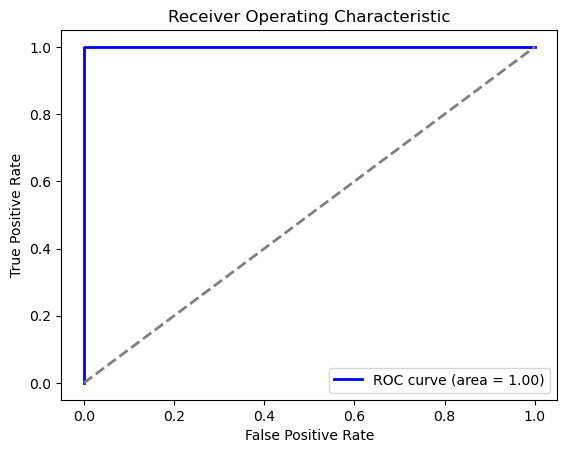

In [23]:
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [24]:
X_train_selected = X_train.loc[:, rfe.support_]
# print(X_train_selected)

X_train_selected = sm.add_constant(X_train_selected)
logit_model = sm.Logit(y_train, X_train_selected)
result = logit_model.fit(method='bfgs')

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 30
         Function evaluations: 33
         Gradient evaluations: 33
                           Logit Regression Results                           
Dep. Variable:                bending   No. Observations:                   69
Model:                          Logit   Df Residuals:                       61
Method:                           MLE   Df Model:                            7
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                   1.000
Time:                        23:34:51   Log-Likelihood:            -4.0865e-05
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 3.041e-09
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               

### (b) Binary Classification Using L1-penalized logistic regression


#### i. 
Repeat 2(a)iii using L1-penalized logistic regression, i.e., instead of using p-values for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and λ, the weight of L1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for λ automatically.


In [25]:
folders = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
num_tests = [2, 2, 3, 3, 3, 3, 3]
split_n = [i for i in range(1, 21)]
results = {}
model = LogisticRegression(penalty='l1', solver='liblinear')
params = {
    'C': np.linspace(0, 10, 20)
    }

for n in split_n:
    training_data = []
    for folder, num_test in zip(folders, num_tests):
        training, _ = split_into_n(folder, num_test, n)
        training_data.append(training)
    training_data = pd.concat(training_data, ignore_index=True)
    training_data['bending'] = [1 if i < 9 else 0 for i in training_data.index] 

    X_train = training_data.drop('bending', axis=1)
    y_train = training_data['bending']

    grid_search = GridSearchCV(
        estimator=model, 
        param_grid=params, 
        scoring='accuracy',  # Can also use 'f1', 'roc_auc', or other scoring methods
        cv=5,                # 5-fold cross-validation  
    )  
    grid_search.fit(X_train, y_train)

    results[f'Split {n}'] = {
        'Best C': grid_search.best_params_['C'].round(2),
        'Optimal num of features': grid_search.best_estimator_.coef_.shape[1],
        'Accuracy': grid_search.best_score_
    }

In [26]:
for key, value in sorted(results.items(), key=lambda x: x[1]['Accuracy']):
    print(f"{key}: {value}")

Split 9: {'Best C': 1.58, 'Optimal num of features': 135, 'Accuracy': 0.8274725274725275}
Split 15: {'Best C': 0.53, 'Optimal num of features': 225, 'Accuracy': 0.8274725274725275}
Split 17: {'Best C': 0.53, 'Optimal num of features': 255, 'Accuracy': 0.8274725274725275}
Split 11: {'Best C': 0.53, 'Optimal num of features': 165, 'Accuracy': 0.8417582417582418}
Split 18: {'Best C': 0.53, 'Optimal num of features': 270, 'Accuracy': 0.8417582417582418}
Split 20: {'Best C': 0.53, 'Optimal num of features': 300, 'Accuracy': 0.8417582417582418}
Split 10: {'Best C': 7.37, 'Optimal num of features': 150, 'Accuracy': 0.856043956043956}
Split 19: {'Best C': 0.53, 'Optimal num of features': 285, 'Accuracy': 0.856043956043956}
Split 7: {'Best C': 0.53, 'Optimal num of features': 105, 'Accuracy': 0.8703296703296702}
Split 8: {'Best C': 0.53, 'Optimal num of features': 120, 'Accuracy': 0.8703296703296702}
Split 12: {'Best C': 1.05, 'Optimal num of features': 180, 'Accuracy': 0.8703296703296702}
Spli


#### ii. 
Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

In [27]:
best_n, best_l, best_c = 1, 15, 4.2

folders = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
num_tests = [2, 2, 3, 3, 3, 3, 3]

training_data = []
for folder, num_test in zip(folders, num_tests):
    training, _ = split_into_n(folder, num_test, n)
    training_data.append(training)
training_data = pd.concat(training_data, ignore_index=True)

training_data['bending'] = [1 if i < 9 else 0 for i in training_data.index] 

X_train = training_data.drop('bending', axis=1)
y_train = training_data['bending']
model = LogisticRegression(penalty='l1', solver='liblinear', C=best_c)
model = RFE(estimator=model, n_features_to_select=best_l)
model = model.fit(X_train, y_train)

y_pred = model.predict(X_train)

conf_matrix = confusion_matrix(y_train, y_pred)
print("Confusion Matrix: \n", conf_matrix)

Confusion Matrix: 
 [[60  0]
 [ 0  9]]


In [28]:
X_train_selected = X_train.loc[:, model.support_]

X_train_selected = sm.add_constant(X_train_selected)
logit_model = sm.Logit(y_train, X_train_selected)
result = logit_model.fit(method='bfgs')

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
                           Logit Regression Results                           
Dep. Variable:                bending   No. Observations:                   69
Model:                          Logit   Df Residuals:                       53
Method:                           MLE   Df Model:                           15
Date:                Tue, 22 Oct 2024   Pseudo R-squ.:                   1.000
Time:                        23:35:08   Log-Likelihood:            -1.9166e-05
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 3.263e-06
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               

Previous model is easier to implement as it has fewer features. The p-value of both model are the same so it is hard to say which one is better.

### (c) Multi-class Classification (The Realistic Case)


#### i. 
Find the best l in the same way as you found it in 2(b)i to build an L1-penalized multinomial regression model to classify all activities in your training set. Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.


In [29]:
folders = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
num_tests = [2, 2, 3, 3, 3, 3, 3]
split_n = [i for i in range(1, 21)]
results = {}
model = LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial')
params = {
    'C': np.linspace(0, 10, 20)
    }

for n in split_n:
    training_data = []
    label_count = 0
    for folder, num_test in zip(folders, num_tests):
        training, _ = split_into_n(folder, num_test, n)
        training['label'] = label_count
        label_count += 1
        training_data.append(training)
    training_data = pd.concat(training_data, ignore_index=True)

    X_train = training_data.drop('label', axis=1)
    y_train = training_data['label']

    grid_search = GridSearchCV(
        estimator=model, 
        param_grid=params, 
        scoring='accuracy',  # Can also use 'f1', 'roc_auc', or other scoring methods
        cv=5,                # 5-fold cross-validation  
    )  
    grid_search.fit(X_train, y_train)

    results[f'Split {n}'] = {
        'Best C': grid_search.best_params_['C'].round(2),
        'Optimal num of features': grid_search.best_estimator_.coef_.shape[1],
        'Accuracy': grid_search.best_score_
    }

In [30]:
for key, value in sorted(results.items(), key=lambda x: x[1]['Accuracy']):
    print(f"{key}: {value}")

Split 8: {'Best C': 6.84, 'Optimal num of features': 120, 'Accuracy': 0.6098901098901098}
Split 11: {'Best C': 0.53, 'Optimal num of features': 165, 'Accuracy': 0.6098901098901098}
Split 7: {'Best C': 0.53, 'Optimal num of features': 105, 'Accuracy': 0.6109890109890109}
Split 10: {'Best C': 1.58, 'Optimal num of features': 150, 'Accuracy': 0.6109890109890109}
Split 16: {'Best C': 3.68, 'Optimal num of features': 240, 'Accuracy': 0.6109890109890109}
Split 17: {'Best C': 2.11, 'Optimal num of features': 255, 'Accuracy': 0.6109890109890109}
Split 18: {'Best C': 2.11, 'Optimal num of features': 270, 'Accuracy': 0.6109890109890109}
Split 19: {'Best C': 2.11, 'Optimal num of features': 285, 'Accuracy': 0.6109890109890109}
Split 2: {'Best C': 1.58, 'Optimal num of features': 30, 'Accuracy': 0.6241758241758243}
Split 4: {'Best C': 1.05, 'Optimal num of features': 60, 'Accuracy': 0.6241758241758243}
Split 15: {'Best C': 1.58, 'Optimal num of features': 225, 'Accuracy': 0.6241758241758243}
Split

In [31]:
best_n, best_l, best_c = 3, 45, 1.05

folders = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
num_tests = [2, 2, 3, 3, 3, 3, 3]
model = LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', C=best_c)

label_count = 0
training_data, testing_data = [], []
for folder, num_test in zip(folders, num_tests):
    training, testing = split_into_n(folder, num_test, n)
    training['label'] = label_count
    testing['label'] = label_count
    label_count += 1
    training_data.append(training)
    testing_data.append(testing)
training_data = pd.concat(training_data, ignore_index=True)
testing_data = pd.concat(testing_data, ignore_index=True)

X_train = training_data.drop('label', axis=1)
y_train = training_data['label']
X_test = testing_data.drop('label', axis=1)
y_test = testing_data['label']

rfe = RFE(estimator=model, n_features_to_select=best_l)
rfe = rfe.fit(X_train, y_train)

y_pred = rfe.predict(X_test)
score = rfe.score(X_test, y_test)
conf_matrix = confusion_matrix(y_test, y_pred)

print('Test Error: ', 1 - score)
print('Confusion Matrix: \n', conf_matrix)

Test Error:  0.3157894736842105
Confusion Matrix: 
 [[1 0 0 0 0 1 0]
 [1 0 0 0 0 1 0]
 [0 0 3 0 0 0 0]
 [0 0 0 2 0 1 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]


In [32]:
num_classes = len(set(y_train)) 
y_train_bin = label_binarize(y_train, classes=[i for i in range(num_classes)])
y_pred_prob = rfe.predict_proba(X_train)

fpr = {}
tpr = {}
roc_auc = {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = roc_auc_score(y_train_bin[:, i], y_pred_prob[:, i])
    print(f"ROC AUC for class {i}: {roc_auc[i]}")

roc_auc_macro = roc_auc_score(y_train_bin, y_pred_prob, average='macro')
print("Macro-average ROC AUC: ", roc_auc_macro)

roc_auc_micro = roc_auc_score(y_train_bin, y_pred_prob, average='micro')
print("Micro-average ROC AUC: ", roc_auc_micro)

ROC AUC for class 0: 1.0
ROC AUC for class 1: 0.9923076923076923
ROC AUC for class 2: 1.0
ROC AUC for class 3: 0.9473684210526316
ROC AUC for class 4: 0.9868421052631579
ROC AUC for class 5: 0.97953216374269
ROC AUC for class 6: 1.0
Macro-average ROC AUC:  0.9865786260523103
Micro-average ROC AUC:  0.9863474060071414


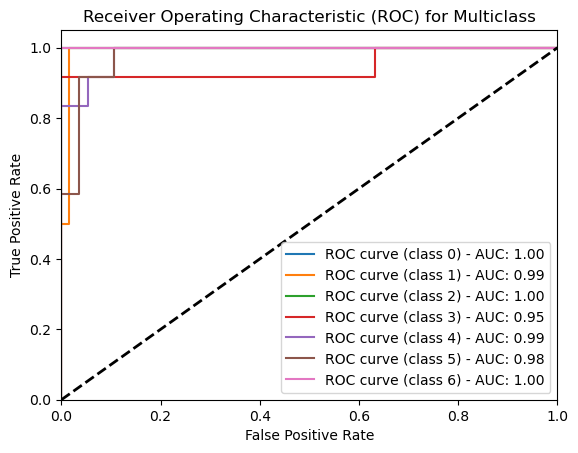

In [33]:
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) - AUC: {roc_auc[i]:.2f}')
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Multiclass')
plt.legend(loc="lower right")
plt.show()


#### ii. 
Repeat 2(c)i using a Naïve Bayes’ classifier. Use both Gaussian and Multinomial priors and compare the results.


In [34]:
folders = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
num_tests = [2, 2, 3, 3, 3, 3, 3]
split_n = [i for i in range(1, 21)]
results_gaussian = {}
results_multinomial = {}

gaussian_model = GaussianNB()
multinomial_model = MultinomialNB()

for n in split_n:
    training_data = []
    label_count = 0
    for folder, num_test in zip(folders, num_tests):
        training, _ = split_into_n(folder, num_test, n)
        training['label'] = label_count
        label_count += 1
        training_data.append(training)
    training_data = pd.concat(training_data, ignore_index=True)

    X_train = training_data.drop('label', axis=1)
    y_train = training_data['label']

    grid_search_gaussian = GridSearchCV(
        estimator=gaussian_model, 
        param_grid={}, 
        scoring='accuracy',
        cv=5 
    )  
    grid_search_gaussian.fit(X_train, y_train)

    results_gaussian[f'Split {n}'] = {
        'Optimal num of features': grid_search_gaussian.best_estimator_.theta_.shape[1],
        'Accuracy': grid_search_gaussian.best_score_
    }

    grid_search_multinomial = GridSearchCV(
        estimator=multinomial_model, 
        param_grid={}, 
        scoring='accuracy',
        cv=5  
    )  
    grid_search_multinomial.fit(X_train, y_train)

    results_multinomial[f'Split {n}'] = {
        'Optimal num of features': grid_search_multinomial.best_estimator_.feature_count_.shape[1],
        'Accuracy': grid_search_multinomial.best_score_
    }

In [35]:
print("Results for GaussianNB:")
for key, value in sorted(results_gaussian.items(), key=lambda x: x[1]['Accuracy']):
    print(f"{key}: {value}")

print("\nResults for MultinomialNB:")
for key, value in sorted(results_multinomial.items(), key=lambda x: x[1]['Accuracy']):
    print(f"{key}: {value}")

Results for GaussianNB:
Split 19: {'Optimal num of features': 285, 'Accuracy': 0.6824175824175824}
Split 15: {'Optimal num of features': 225, 'Accuracy': 0.710989010989011}
Split 13: {'Optimal num of features': 195, 'Accuracy': 0.7120879120879121}
Split 14: {'Optimal num of features': 210, 'Accuracy': 0.7120879120879121}
Split 17: {'Optimal num of features': 255, 'Accuracy': 0.7120879120879121}
Split 18: {'Optimal num of features': 270, 'Accuracy': 0.7120879120879121}
Split 9: {'Optimal num of features': 135, 'Accuracy': 0.7252747252747253}
Split 10: {'Optimal num of features': 150, 'Accuracy': 0.7252747252747253}
Split 12: {'Optimal num of features': 180, 'Accuracy': 0.7252747252747253}
Split 20: {'Optimal num of features': 300, 'Accuracy': 0.7274725274725276}
Split 11: {'Optimal num of features': 165, 'Accuracy': 0.7395604395604395}
Split 16: {'Optimal num of features': 240, 'Accuracy': 0.7395604395604396}
Split 8: {'Optimal num of features': 120, 'Accuracy': 0.7406593406593407}
Spli

### Test Gaussian

In [36]:
best_n, best_l = 1, 15

folders = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
num_tests = [2, 2, 3, 3, 3, 3, 3]
model = GaussianNB()

label_count = 0
training_data, testing_data = [], []
for folder, num_test in zip(folders, num_tests):
    training, testing = split_into_n(folder, num_test, n)
    training['label'] = label_count
    testing['label'] = label_count
    label_count += 1
    training_data.append(training)
    testing_data.append(testing)
training_data = pd.concat(training_data, ignore_index=True)
testing_data = pd.concat(testing_data, ignore_index=True)

X_train = training_data.drop('label', axis=1)
y_train = training_data['label']
X_test = testing_data.drop('label', axis=1)
y_test = testing_data['label']

selector = SelectKBest(score_func=f_classif, k=best_l) 

X_train = selector.fit_transform(X_train, y_train)
model = model.fit(X_train, y_train)

X_test = selector.transform(X_test)
y_pred = model.predict(X_test)
score = model.score(X_test, y_test)

print('Test Error: ', 1 - score)
print('Confusion Matrix: \n', conf_matrix)

Test Error:  0.5263157894736843
Confusion Matrix: 
 [[1 0 0 0 0 1 0]
 [1 0 0 0 0 1 0]
 [0 0 3 0 0 0 0]
 [0 0 0 2 0 1 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]


### Test Multinomial

In [37]:
best_n, best_l = 5, 75

folders = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
num_tests = [2, 2, 3, 3, 3, 3, 3]
model = MultinomialNB()

label_count = 0
training_data, testing_data = [], []
for folder, num_test in zip(folders, num_tests):
    training, testing = split_into_n(folder, num_test, n)
    training['label'] = label_count
    testing['label'] = label_count
    label_count += 1
    training_data.append(training)
    testing_data.append(testing)
training_data = pd.concat(training_data, ignore_index=True)
testing_data = pd.concat(testing_data, ignore_index=True)

X_train = training_data.drop('label', axis=1)
y_train = training_data['label']
X_test = testing_data.drop('label', axis=1)
y_test = testing_data['label']

selector = SelectKBest(score_func=f_classif, k=best_l) 

X_train = selector.fit_transform(X_train, y_train)
model = model.fit(X_train, y_train)

X_test = selector.transform(X_test)
y_pred = model.predict(X_test)
score = model.score(X_test, y_test)

print('Test Error: ', 1 - score)
print('Confusion Matrix: \n', conf_matrix)

Test Error:  0.4736842105263158
Confusion Matrix: 
 [[1 0 0 0 0 1 0]
 [1 0 0 0 0 1 0]
 [0 0 3 0 0 0 0]
 [0 0 0 2 0 1 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]



#### iii. 
Which method is better for multi-class classification in this problem?

Comparing Gaussian and Multinomial in Naive Bayes, Multinomial has lower testing error so it is better than Gaussian in this case.

## 3. ISLR, 4.8.3

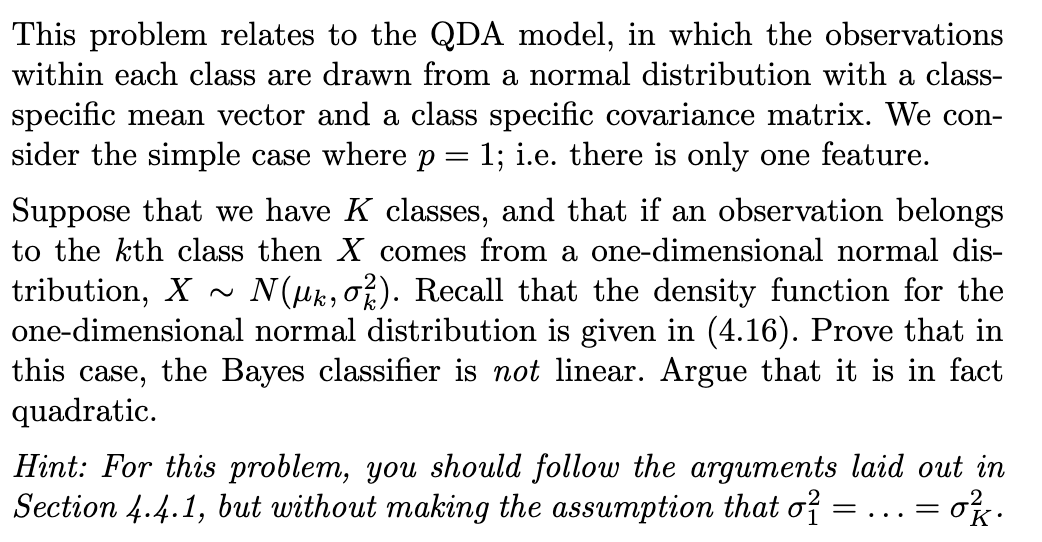

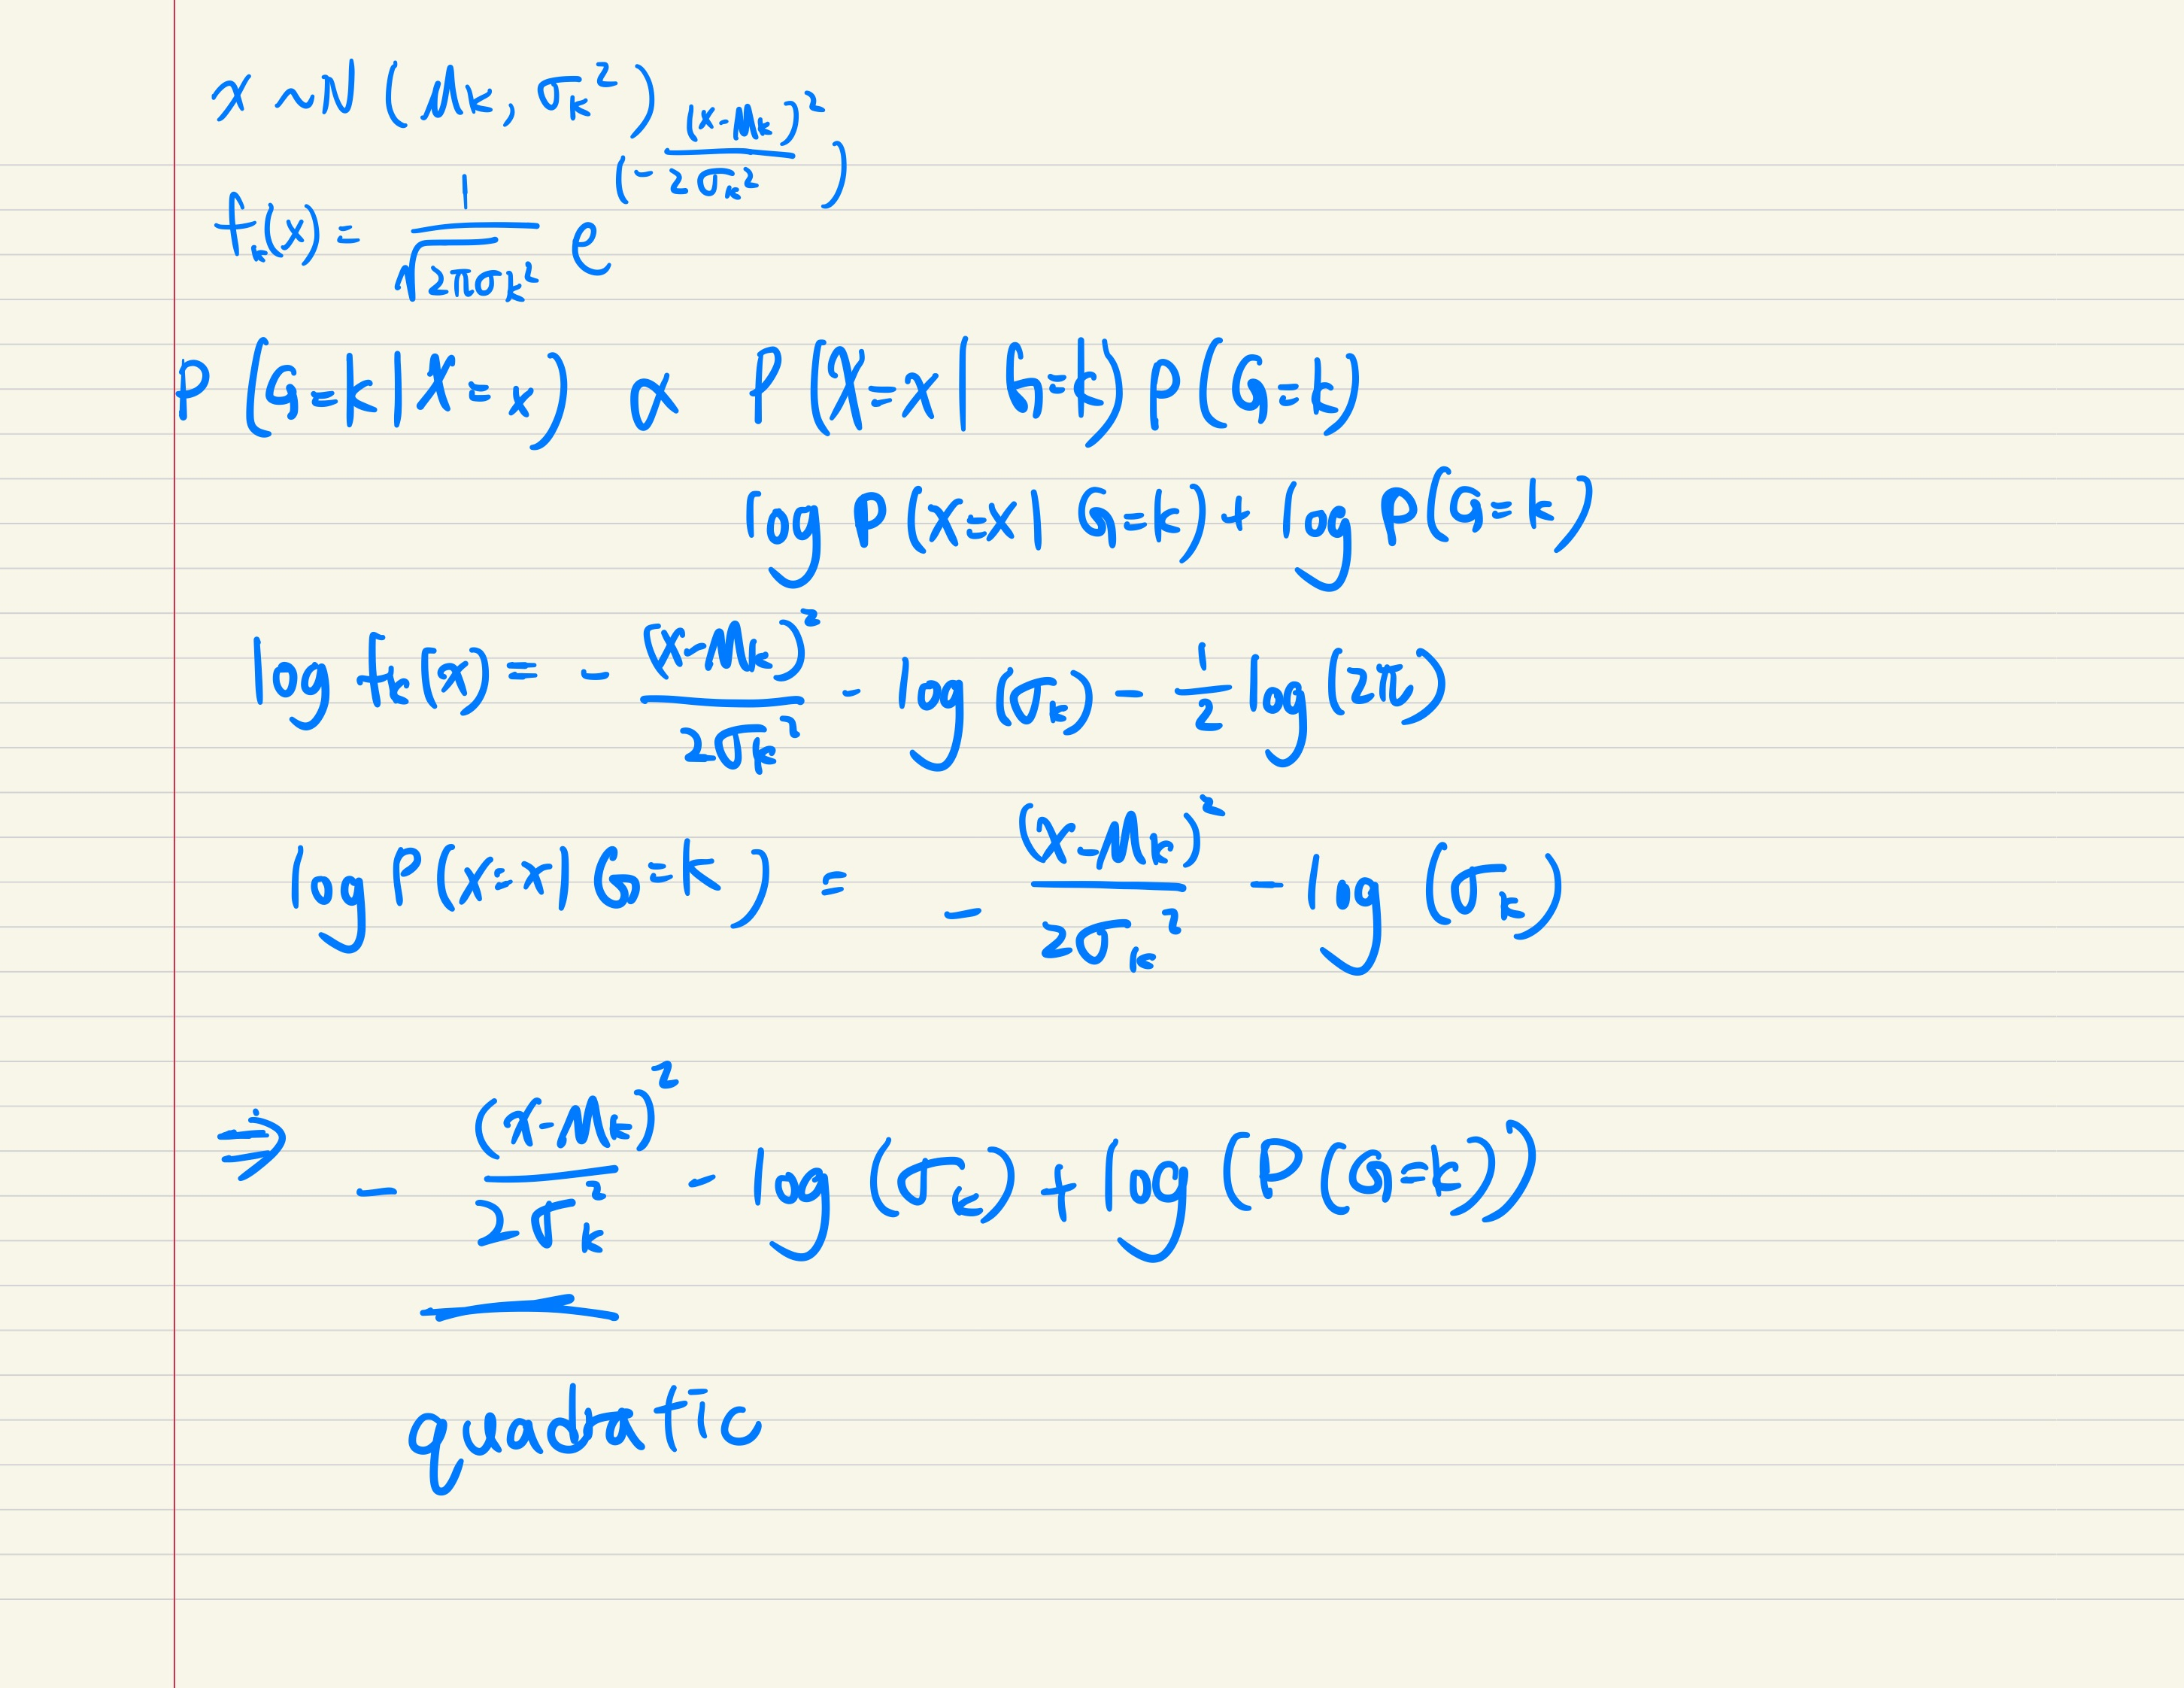

In [38]:
from IPython.display import Image, display

# Display the image
display(Image(filename='../img/4.8.3.png'))
display(Image(filename='../img/4.8.3ans.jpg'))

## 4. ISLR 4.8.7

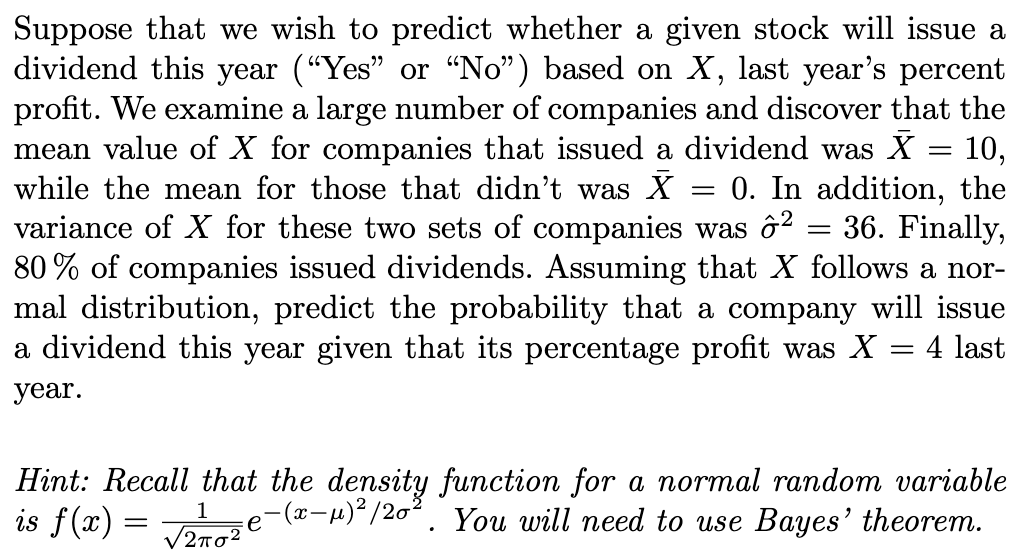

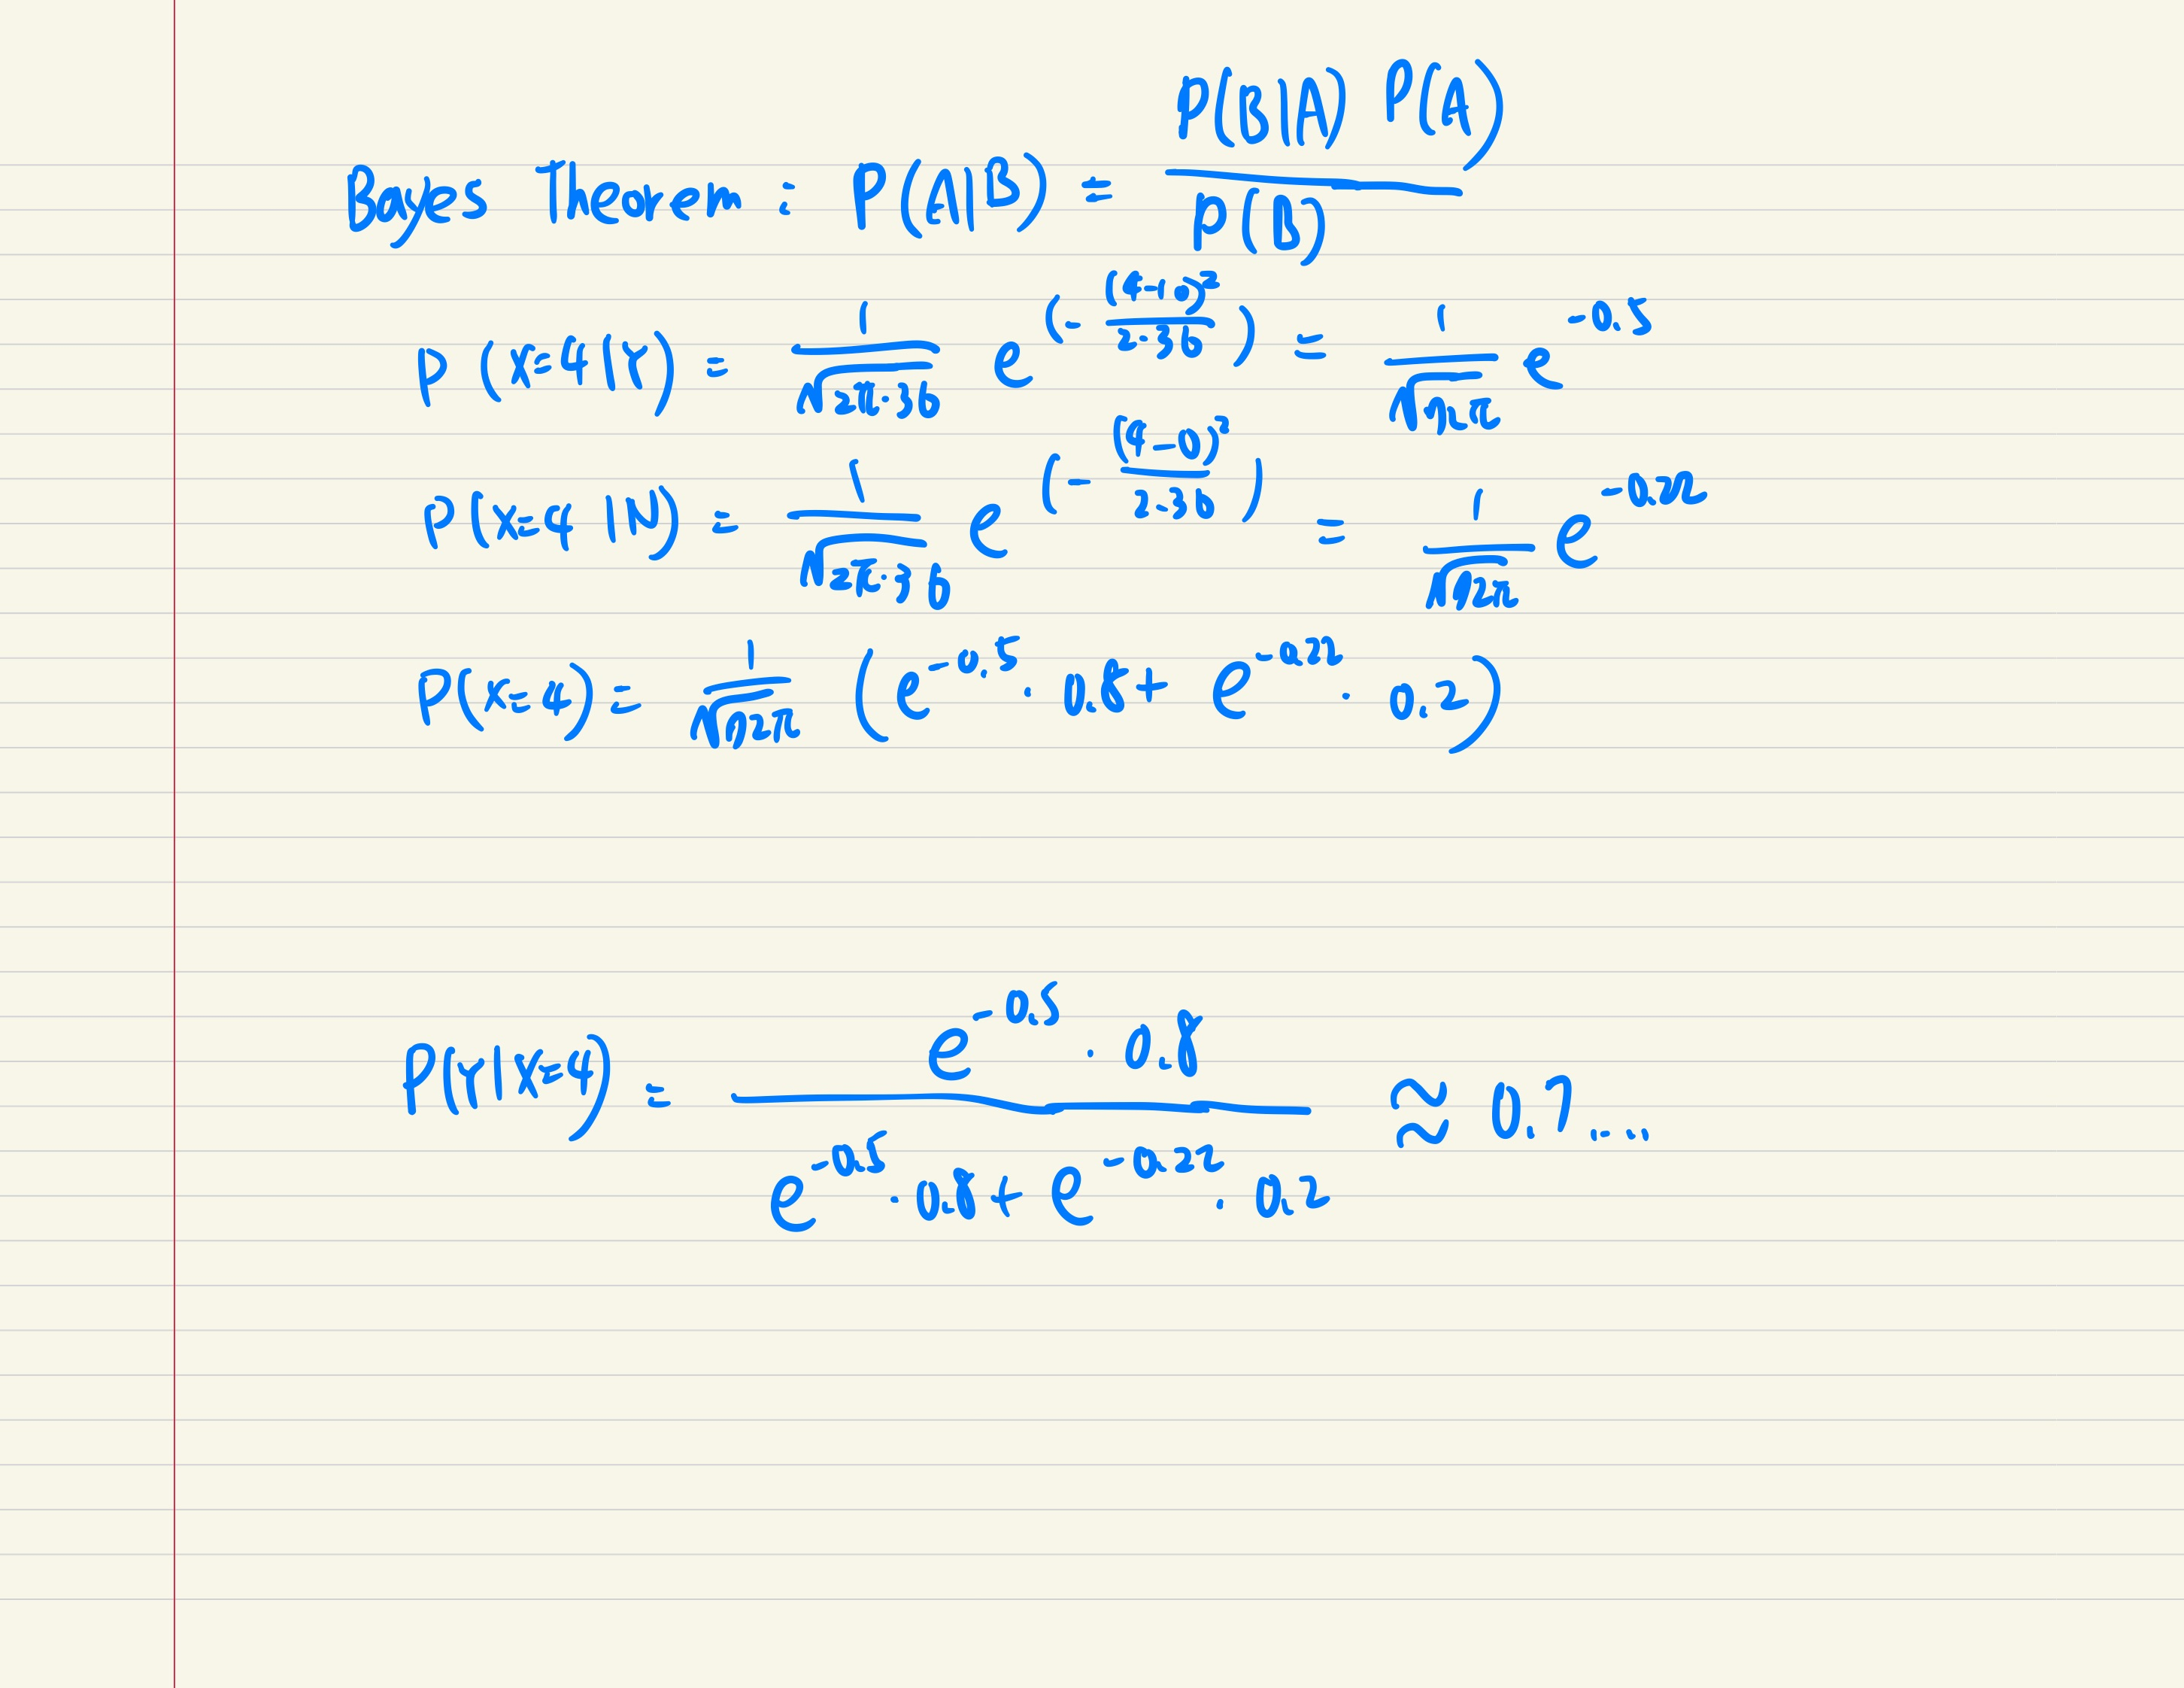

In [39]:
display(Image(filename='../img/4.8.7.png'))
display(Image(filename='../img/4.8.7ans.jpg'))